In [2]:
!pip install pandas

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

print(tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
print(device_name)

2.7.0
1
/device:GPU:0


In [4]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()
#x_train = x_train.reshape(-1, 28, 28, 1)
#x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255
#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [5]:
x_train.shape
x_test.shape

(10000, 32, 32, 3)

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [7]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu',padding='same'),
        keras.layers.BatchNormalization(name="bn1"),  
        keras.layers.Conv2D(32, (3, 3),name="conv2", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn2"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(64, (3, 3),name="conv3", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn3"),
        keras.layers.Conv2D(64, (3, 3),name="conv4", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn4"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(128, (3, 3),name="conv5", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn5"),
        keras.layers.Conv2D(128, (3, 3),name="conv6", activation='relu', padding='same'),
        keras.layers.BatchNormalization(name="bn6"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp3"),
        keras.layers.Dropout(0.4),
     
        keras.layers.Flatten(name = "flatten"),
        #keras.layers.Dropout(0.2, name="dp1"),
        #keras.layers.Dense(512, name="dense1", activation='relu'),
        #keras.layers.BatchNormalization(name="bn7"),
        #keras.layers.Dropout(0.4),
        #keras.layers.Dense(256, name="dense2", activation='relu'),
        #keras.layers.BatchNormalization(name="bn8"),
        #keras.layers.Dropout(0.2),
        keras.layers.Dense(1024, name="dense3", activation='relu'),
        keras.layers.BatchNormalization(name="bn9"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, name="dense4", activation='softmax')
    ],
    name="modelo-0.0",
)

for layer in model.trainable_variables:
    #print(layer.name)
    if 'bias' in layer.name:
        new_bias = tf.cast(tf.where(tf.abs(layer) >= 0, 0.1, 0.1), tf.float32)
        layer.assign(new_bias)

model.summary()

Model: "modelo-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (64, 32, 32, 32)          896       
                                                                 
 bn1 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 conv2 (Conv2D)              (64, 32, 32, 32)          9248      
                                                                 
 bn2 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 mp1 (MaxPooling2D)          (64, 16, 16, 32)          0         
                                                                 
 dropout (Dropout)           (64, 16, 16, 32)          0         
                                                                 
 conv3 (Conv2D)              (64, 16, 16, 64)          1

In [8]:
epochs = 250
alpha = 0
n_bits = 4

learning_rate = 0.005
momentum = 0.9

np.set_printoptions(threshold=np.inf)

model_sparsity = np.array([])
model_train_loss = np.array([])
model_train_acc = np.array([])
model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

last_test_acc = 0
model_name = "test_q3.h5"


with tf.device('/device:GPU:0'):
    #TODO: Quantizition of gammas and betas of batch_normalization layer
    for epoch in range(epochs):
        # Iterate over the batches of the dataset.
        loss_batch = np.array([])
        loss_test_batch = np.array([])
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            n_zeros = 0
            size = 0
            #pruning
            if alpha > 0:
                bk = []
                for layer_weights in model.trainable_variables:
                    if 'bn' in layer_weights.name:
                        bk.append(-1)
                    else:
                        #flatten weights
                        f_weights = tf.reshape(layer_weights,[-1])
                        #get standard deviation of each layer
                        lim = alpha*tf.math.reduce_std(f_weights)
                        bk.append(lim)
                        #create a mask
                        mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)
                        #assign pruned weights to the layer
                        layer_weights.assign(tf.math.multiply(layer_weights,mask))
                        #check sparsity
                        flat_array = np.array((tf.reshape(mask,[-1])))
                        n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                        size += flat_array.shape[0]
                        sparsity = n_zeros*100/size
            else:
                bk = [0] * len(model.trainable_weights)

            #Cópia do modelo
            if n_bits > 0:
                model_copy = keras.models.clone_model(model)
                model_copy.set_weights(model.get_weights())
        
            #Quantização
            if n_bits > 0:
                for i, layer_weights in enumerate(model.trainable_variables):
                    if 'bn' in layer_weights.name:
                        pass
                    else:
                        qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                        ck = tf.math.round(layer_weights / qk_line) * qk_line
                        layer_weights.assign(ck)

            with tf.GradientTape() as tape:
                pred = model(x_batch_train, training=True)
                loss = loss_fn(y_batch_train, pred)
          
            grads = tape.gradient(loss, model.trainable_weights)
            if step==0 and epoch==0:
                print("Created Tensor of velocity")
                v = np.zeros_like(grads)
            if n_bits > 0:
                for i, (layer_weights, copied_weights) in enumerate(zip(model.trainable_variables, model_copy.trainable_variables)):
                    #TODO: Add momentum and velocity
                    grads[i] = grads[i] * learning_rate
                    #Get value of velocity
                    v[i] = tf.math.subtract(momentum*v[i], grads[i])
                    # WEIGHT UPDATE
                    layer_weights.assign(tf.math.add(copied_weights, v[i]))
            else:
                for i, layer_weights in enumerate(model.trainable_variables):
                    
                    grads[i] = grads[i] * learning_rate
                    v[i] = tf.math.subtract(momentum*v[i], grads[i])
                    #WEIGHT UPDATE
                    layer_weights.assign(tf.math.add(layer_weights, v[i]))
            predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
            train_accuracy.update_state(y_batch_train,predictions)

            #predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
            #acc = train_accuracy(y_batch_train, predictions)

        #keep track of loss by batch
            loss_batch = np.append(loss_batch, loss)
        acc = train_accuracy.result()

        #reset states
        train_accuracy.reset_states()
        #mean of loss by epoch
        model_train_loss = np.append(model_train_loss, np.mean(loss_batch))
        #train accuracy by epoch
        model_train_acc = np.append(model_train_acc, acc*100)
        #sparsity by epoch
        model_sparsity = np.append(model_sparsity, sparsity)

        if alpha > 0:
            bk = []
            for layer_weights in model.trainable_variables:
                if 'bn' in layer_weights.name:
                    bk.append(-1)
                else:
                    #flatten weights
                    f_weights = tf.reshape(layer_weights,[-1])
                    #get standard deviation of each layer
                    lim = alpha*tf.math.reduce_std(f_weights)
                    bk.append(lim)
                    #create a mask
                    mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)
                    #assign pruned weights to the layer
                    layer_weights.assign(tf.math.multiply(layer_weights,mask))
                    #check sparsity
                    flat_array = np.array((tf.reshape(mask,[-1])))
                    n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                    size += flat_array.shape[0]
                    sparsity = n_zeros*100/size
        else:
            bk = [0] * len(model.trainable_weights)

        #Quantização
        if n_bits > 0:
                for i, layer_weights in enumerate(model.trainable_variables):
                    if 'bn' in layer_weights.name:
                        pass
                    else:
                        qk_line = (tf.reduce_max(tf.math.abs(layer_weights)) - bk[i]) / (2 ** (n_bits - 1) - 1)
                        ck = tf.math.round(layer_weights / qk_line) * qk_line
                        layer_weights.assign(ck)
      
        #bk.clear()
        
        #Test
        acc_val = np.array([])
        for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
            test_pred = model(x_batch_test, training=False)
            test_loss = loss_fn(y_batch_test,test_pred)
            test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
            #test_acc = test_accuracy(y_batch_test, test_prediction)
                
            #acc_val = np.append(acc_val,float(test_acc))

            loss_test_batch = np.append(loss_test_batch,test_loss)
            test_accuracy.update_state(y_batch_test,test_prediction)

        test_acc = test_accuracy.result()
        test_accuracy.reset_states()

        model_test_acc = np.append(model_test_acc, test_acc*100)
        model_test_loss = np.append(model_test_loss,np.mean(loss_test_batch))
        
        print("Epoch {}/{} \t Loss = {:.3f} \t Train Acc = {:.3f}% \t Sparsity = {:.3f}% \t Test Loss = {:.3f} \tTest Acc = {:.3f}%".format(epoch+1,epochs,float(np.mean(loss_batch)),float(acc*100),sparsity, float(np.mean(loss_test_batch)),float(test_acc*100)))

        if last_test_acc < test_acc:
            print('New test accuracy is {:.3f}%, Model saved'.format(test_acc*100))
            last_test_acc = test_acc
            model.save(model_name)



data = {'train accuracy': model_train_acc, 'test accuracy': model_test_acc, 'sparsity': model_sparsity, 'train loss': model_train_loss, 'test loss': model_test_loss}

df = pd.DataFrame(data)

df.to_csv('test_q3.csv')

Created Tensor of velocity


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/250 	 Loss = 1.949 	 Train Acc = 37.934% 	 Sparsity = 0.000% 	 Test Loss = 1.722 	Test Acc = 42.340%
New test accuracy is 42.340%, Model saved
Epoch 2/250 	 Loss = 1.452 	 Train Acc = 51.180% 	 Sparsity = 0.000% 	 Test Loss = 1.503 	Test Acc = 52.880%
New test accuracy is 52.880%, Model saved
Epoch 3/250 	 Loss = 1.199 	 Train Acc = 59.650% 	 Sparsity = 0.000% 	 Test Loss = 1.090 	Test Acc = 62.930%
New test accuracy is 62.930%, Model saved
Epoch 4/250 	 Loss = 1.053 	 Train Acc = 64.358% 	 Sparsity = 0.000% 	 Test Loss = 0.928 	Test Acc = 67.940%
New test accuracy is 67.940%, Model saved
Epoch 5/250 	 Loss = 0.969 	 Train Acc = 67.048% 	 Sparsity = 0.000% 	 Test Loss = 0.878 	Test Acc = 69.270%
New test accuracy is 69.270%, Model saved
Epoch 6/250 	 Loss = 0.919 	 Train Acc = 68.828% 	 Sparsity = 0.000% 	 Test Loss = 0.789 	Test Acc = 73.020%
New test accuracy is 73.020%, Model saved
Epoch 7/250 	 Loss = 0.883 	 Train Acc = 69.950% 	 Sparsity = 0.000% 	 Test Loss = 0.761 	Test

Epoch 45/250 	 Loss = 0.650 	 Train Acc = 77.406% 	 Sparsity = 0.000% 	 Test Loss = 0.613 	Test Acc = 78.820%
Epoch 46/250 	 Loss = 0.650 	 Train Acc = 77.342% 	 Sparsity = 0.000% 	 Test Loss = 0.589 	Test Acc = 79.780%
Epoch 47/250 	 Loss = 0.646 	 Train Acc = 77.746% 	 Sparsity = 0.000% 	 Test Loss = 0.590 	Test Acc = 79.480%
Epoch 48/250 	 Loss = 0.645 	 Train Acc = 77.486% 	 Sparsity = 0.000% 	 Test Loss = 0.601 	Test Acc = 79.350%
Epoch 49/250 	 Loss = 0.650 	 Train Acc = 77.298% 	 Sparsity = 0.000% 	 Test Loss = 0.597 	Test Acc = 79.130%
Epoch 50/250 	 Loss = 0.647 	 Train Acc = 77.024% 	 Sparsity = 0.000% 	 Test Loss = 0.584 	Test Acc = 79.770%
Epoch 51/250 	 Loss = 0.640 	 Train Acc = 77.792% 	 Sparsity = 0.000% 	 Test Loss = 0.587 	Test Acc = 79.900%
Epoch 52/250 	 Loss = 0.644 	 Train Acc = 77.490% 	 Sparsity = 0.000% 	 Test Loss = 0.593 	Test Acc = 79.140%
Epoch 53/250 	 Loss = 0.648 	 Train Acc = 77.448% 	 Sparsity = 0.000% 	 Test Loss = 0.602 	Test Acc = 78.980%
Epoch 54/2

Epoch 112/250 	 Loss = 0.611 	 Train Acc = 78.362% 	 Sparsity = 0.000% 	 Test Loss = 0.587 	Test Acc = 79.590%
Epoch 113/250 	 Loss = 0.613 	 Train Acc = 78.354% 	 Sparsity = 0.000% 	 Test Loss = 0.587 	Test Acc = 79.430%
Epoch 114/250 	 Loss = 0.612 	 Train Acc = 78.482% 	 Sparsity = 0.000% 	 Test Loss = 0.579 	Test Acc = 79.750%
Epoch 115/250 	 Loss = 0.611 	 Train Acc = 78.580% 	 Sparsity = 0.000% 	 Test Loss = 0.575 	Test Acc = 80.070%
Epoch 116/250 	 Loss = 0.612 	 Train Acc = 78.802% 	 Sparsity = 0.000% 	 Test Loss = 0.580 	Test Acc = 79.770%
Epoch 117/250 	 Loss = 0.612 	 Train Acc = 78.484% 	 Sparsity = 0.000% 	 Test Loss = 0.578 	Test Acc = 80.010%
Epoch 118/250 	 Loss = 0.611 	 Train Acc = 78.654% 	 Sparsity = 0.000% 	 Test Loss = 0.587 	Test Acc = 79.690%
Epoch 119/250 	 Loss = 0.613 	 Train Acc = 78.398% 	 Sparsity = 0.000% 	 Test Loss = 0.596 	Test Acc = 79.530%
Epoch 120/250 	 Loss = 0.611 	 Train Acc = 78.562% 	 Sparsity = 0.000% 	 Test Loss = 0.623 	Test Acc = 78.400%
E

Epoch 184/250 	 Loss = 0.604 	 Train Acc = 78.746% 	 Sparsity = 0.000% 	 Test Loss = 0.590 	Test Acc = 79.220%
Epoch 185/250 	 Loss = 0.613 	 Train Acc = 78.404% 	 Sparsity = 0.000% 	 Test Loss = 0.587 	Test Acc = 79.330%
Epoch 186/250 	 Loss = 0.610 	 Train Acc = 78.478% 	 Sparsity = 0.000% 	 Test Loss = 0.575 	Test Acc = 79.960%
Epoch 187/250 	 Loss = 0.605 	 Train Acc = 78.734% 	 Sparsity = 0.000% 	 Test Loss = 0.570 	Test Acc = 80.010%
Epoch 188/250 	 Loss = 0.612 	 Train Acc = 78.474% 	 Sparsity = 0.000% 	 Test Loss = 0.584 	Test Acc = 79.470%
Epoch 189/250 	 Loss = 0.611 	 Train Acc = 78.542% 	 Sparsity = 0.000% 	 Test Loss = 0.572 	Test Acc = 79.840%
Epoch 190/250 	 Loss = 0.610 	 Train Acc = 78.506% 	 Sparsity = 0.000% 	 Test Loss = 0.578 	Test Acc = 79.730%
Epoch 191/250 	 Loss = 0.605 	 Train Acc = 78.688% 	 Sparsity = 0.000% 	 Test Loss = 0.572 	Test Acc = 80.090%
Epoch 192/250 	 Loss = 0.608 	 Train Acc = 78.772% 	 Sparsity = 0.000% 	 Test Loss = 0.577 	Test Acc = 79.730%
E

Exception ignored in: <function EagerResourceDeleter.__del__ at 0x000001EB073E4310>
Traceback (most recent call last):
  File "C:\Users\mateu\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 290, in __del__
    gen_resource_variable_ops.destroy_resource_op(
  File "C:\Users\mateu\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 242, in destroy_resource_op
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [9]:
bk

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [14]:
model = keras.models.load_model('test_q3.h5')

conv1/kernel:0


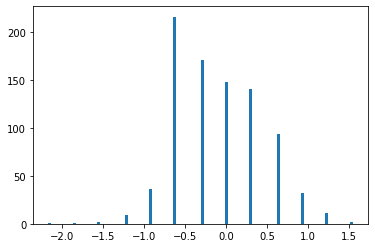

conv2/kernel:0


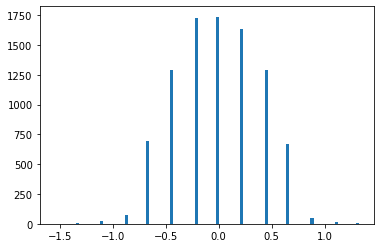

conv3/kernel:0


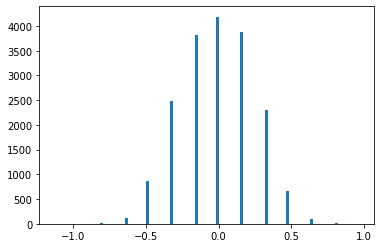

conv4/kernel:0


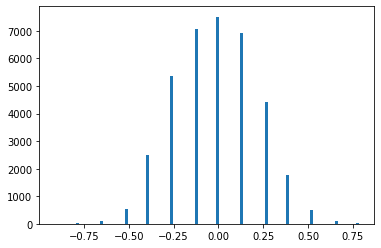

conv5/kernel:0


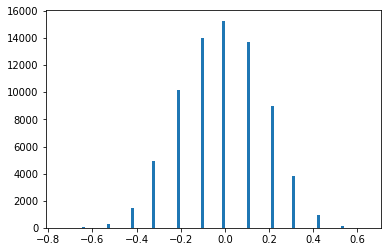

conv6/kernel:0


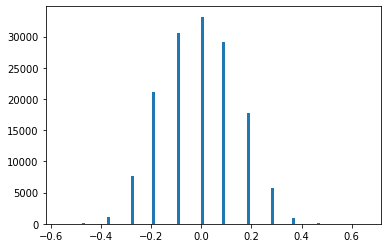

dense3/kernel:0


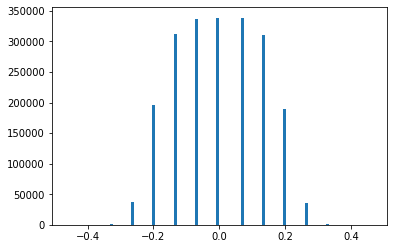

dense4/kernel:0


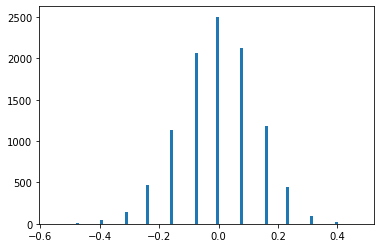

In [16]:
for (i,layer) in enumerate(model.trainable_weights):
        if 'bn' in layer.name or 'bias' in layer.name:
            pass
        else:
            print(layer.name)
            a = tf.reshape(layer,[-1])
            b = a.numpy()
            
            #plt.axvline(x=-bk[i],color='r')
            plt.hist(b,100)
            
            #plt.axvline(x=bk[i],color='r')
            #plt.text(bk[i], 600, 'bk')
            #plt.text(-bk[i], 600, '-bk')
            #plt.ylim([0,10000])
            plt.show()

In [17]:
import pandas as pd

data = {'train accuracy': model_train_acc, 'test accuracy': model_test_acc, 'sparsity': model_sparsity, 'train loss': model_train_loss, 'test loss': model_test_loss}

df = pd.DataFrame(data)

df.to_csv('test_q3.csv')

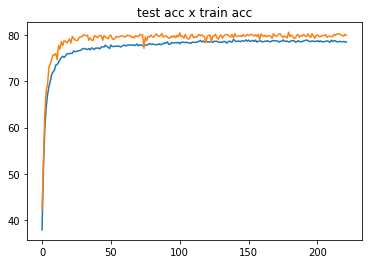

In [18]:
plt.title("test acc x train acc")
plt.plot(model_train_acc)
plt.plot(model_test_acc)
plt.show()

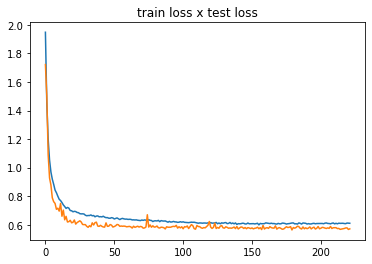

In [19]:
plt.title("train loss x test loss")
plt.plot(model_train_loss)
plt.plot(model_test_loss)
plt.show()

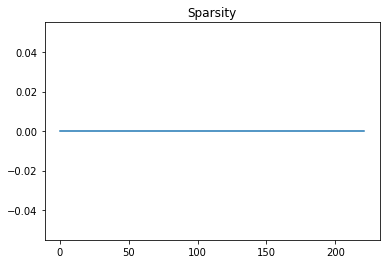

In [20]:
plt.title("Sparsity")
plt.plot(model_sparsity)
plt.show()

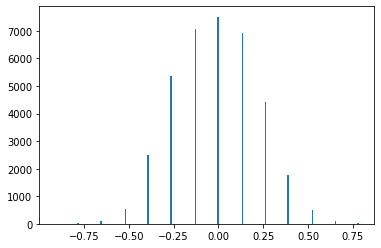

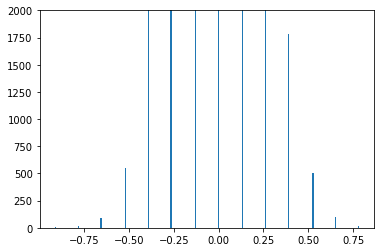

In [21]:
for layer in model.layers:
    if layer.name == 'conv4':
        a = tf.reshape(layer.weights[0],[-1])
        b = a.numpy()
        plt.hist(b,200)
        plt.show()

        plt.hist(b,200)
        plt.ylim((0,2000))
        plt.show()

        

In [23]:
!pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.0.2-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)


In [24]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    figure(figsize=(10, 7), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm[:,0])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]*100/1000) + "%",
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

In [25]:
with tf.device('/device:CPU:0'):
    test_accuracy = tf.keras.metrics.Accuracy()
    logits = model(x_test, training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y_test)
    print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 80.540%


Confusion matrix, without normalization


Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001EB064E9790>
Traceback (most recent call last):
  File "C:\Users\mateu\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


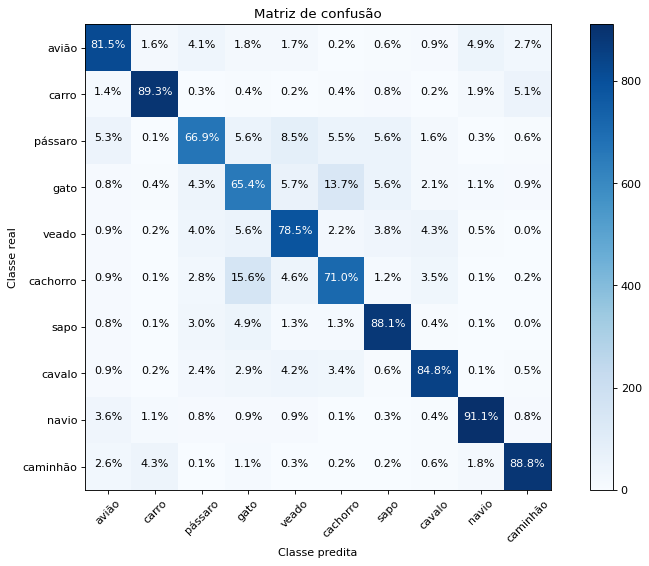

In [26]:
classes = ["avião","carro","pássaro","gato","veado","cachorro","sapo","cavalo","navio","caminhão"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Matriz de confusão')